# Initial training

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd



path = 'smoke_detection_iot.csv'

data = pd.read_csv(path).drop(['Unnamed: 0', 'UTC', 'CNT'], axis=1)
Y_df = data['Fire Alarm']
X_df = data.drop('Fire Alarm', axis=1)

Y_test_raw = X_df.values
Y_raw = Y_df.values

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(Y_test_raw, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.7216206193 | 0.6735410690 |
----------------------------------------
|   500 |  0.0037376164 | 0.0041117766 |
----------------------------------------
|  1000 |  0.0008411370 | 0.0009099907 |
----------------------------------------
|  1500 |  0.0003627229 | 0.0005322006 |
----------------------------------------
|  2000 |  0.0002143461 | 0.0083781751 |
----------------------------------------
|  2500 |  0.0001508159 | 0.0083704693 |
----------------------------------------
Accuracy: 0.9997604981638193
Precision: 0.9998878923766816
Recall: 0.9997758098867839
F1: 0.9998318479905834
Confusion_matrix:
[[3604    1]
 [   2 8919]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0       1.00      1.00      1.00      8921

    accuracy                           1.00 

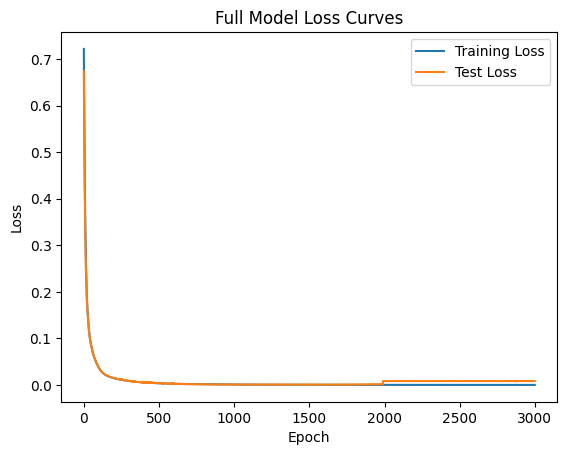

In [2]:
from alarmnetclass import AlarmNet
import torch
from torch import nn

alpha = 1e-2
epochs = 3000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
full_model = AlarmNet(
    num_features=X_train_raw.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)

X_train_raw_device = torch.tensor(X_train_raw).float().to(device)
X_test_raw_device = torch.tensor(X_test_raw).float().to(device)
Y_train_raw_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_raw_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

full_model.train(
    epochs=3000,
    X_train=X_train_raw_device,
    X_test=X_test_raw_device,
    Y_train=Y_train_raw_device,
    Y_test=Y_test_raw_device,
    alpha=1e-2,
    print_epoch = 100
)
full_model.print_results()
full_model.plot_training("Full Model Loss Curves")

# Feature Analysis
- Initially there are 15 features
- 3 are unusable
    - UTC Timestamp
    - CNT
    - Unnamed: 0
- 12 features are usable

In [3]:
import numpy as np



corr = np.abs(data.corr())
ranking = corr['Fire Alarm'].sort_values(ascending=False)[1:]
print(ranking)

Humidity[%]       0.399846
Raw Ethanol       0.340652
Pressure[hPa]     0.249797
TVOC[ppb]         0.214743
Temperature[C]    0.163902
NC0.5             0.128118
PM1.0             0.110552
Raw H2            0.107007
eCO2[ppm]         0.097006
PM2.5             0.084916
NC1.0             0.082828
NC2.5             0.057707
Name: Fire Alarm, dtype: float64


In [4]:
num_drops = 8
remaining_features = ranking.index[:-num_drops]


X_df_dropped = data[remaining_features]
print('Remaining features:', X_df_dropped.columns)
X_train_dropped, X_test_dropped, Y_train_dropped, Y_test_dropped = train_test_split(X_df_dropped.values, Y_raw, test_size=0.2, random_state=0)

X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.transform(X_test_dropped)


Remaining features: Index(['Humidity[%]', 'Raw Ethanol', 'Pressure[hPa]', 'TVOC[ppb]'], dtype='object')


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6725263596 | 0.6668322086 |
----------------------------------------
|   500 |  0.1069645062 | 0.1101157814 |
----------------------------------------
|  1000 |  0.0591031611 | 0.0603733510 |
----------------------------------------
|  1500 |  0.0258244500 | 0.0269234851 |
----------------------------------------
|  2000 |  0.0148819452 | 0.0163811445 |
----------------------------------------
|  2500 |  0.0096148634 | 0.0110829696 |
----------------------------------------
|  3000 |  0.0065433746 | 0.0078589572 |
----------------------------------------
|  3500 |  0.0046671676 | 0.0058539556 |
----------------------------------------
Accuracy: 0.9992814944914578
Precision: 0.9991039426523297
Recall: 0.999887904943392
F1: 0.9994957700711524
Confusion_matrix:
[[3597    8]
 [   1 8920]]
Classification_report:               precision    recall  f1-score  

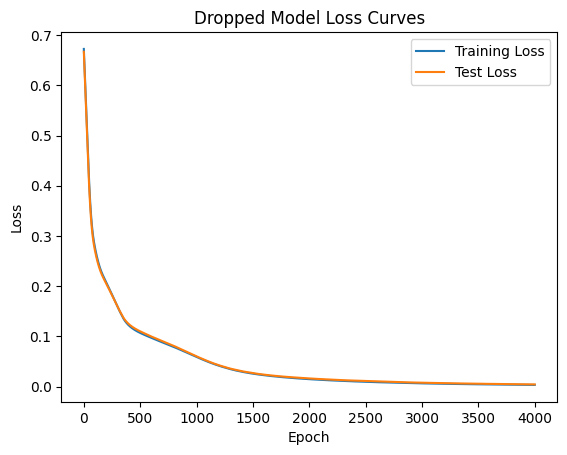

In [5]:
dropped_model = AlarmNet(
    num_features=X_train_dropped.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
    
).to(device)

X_train_dropped_device = torch.tensor(X_train_dropped).float().to(device)
X_test_dropped_device = torch.tensor(X_test_dropped).float().to(device)
Y_train_dropped_device = torch.tensor(Y_train_dropped).float().view(-1, 1).to(device)
Y_test_dropped_device = torch.tensor(Y_test_dropped).float().view(-1, 1).to(device)

dropped_model.train(
    epochs=4000,
    X_train=X_train_dropped_device,
    X_test=X_test_dropped_device,
    Y_train=Y_train_dropped_device,
    Y_test=Y_test_dropped_device,
    alpha=1e-3,
    print_epoch = 500
)
dropped_model.print_results()
AlarmNet.compare_results(dropped_model.get_results(), full_model.get_results())
dropped_model.plot_training("Dropped Model Loss Curves")

## Feature Analysis Results
- We can remove the bottom 8 features and have a model that only loses 0.1% precision, and even less for every other metric
- A 4 feature model is almost perfect
    - These features are:
        - Humidity
        - Raw Ethanol
        - Pressure
        - TVOC

# Error Handling
- The 12 initial features came from 4 sensors
    - Temp/Humidity
    - Pressure
    - Volatile Organic Compounds (CO2, Ethanol, H2, TVOC)
    - Particulate Matter (PM1, PM2.5, NC0.5, NC1, NC2.5)
- 3 of these sensors are redundant, with the exception being the PM sensor
    - This means that the features related to the PM sensor are twice as likely to be missing
- We can simulate a real world scenario by introducing error according to this distribution
- Note that the Particulate Matter sensor is not included in the 4-feature model.
    - To add redundancy to our model, we can add back the most correlated feature from the PM sensor
    - This feature is PM0.5



In [6]:

# Add back the most correlated PM feature, so that all 4 sensors are used
# PM0.5 is the most correlated PM feature, with index 5
remaining_features_2 = list(remaining_features)
remaining_features_2.append(ranking.index[5])
X_5f = data[remaining_features_2]
X_train_5f, X_test_5f, Y_train_5f, Y_test_5f = train_test_split(X_5f.values, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_5f = scaler.fit_transform(X_train_5f)
X_test_5f = scaler.transform(X_test_5f)


----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6827612519 | 0.6218269467 |
----------------------------------------
|   500 |  0.0143062742 | 0.0151378065 |
----------------------------------------
|  1000 |  0.0120598115 | 0.0125640659 |
----------------------------------------
|  1500 |  0.0047366857 | 0.0051539899 |
----------------------------------------
|  2000 |  0.0023963503 | 0.0026061884 |
----------------------------------------
|  2500 |  0.0014390808 | 0.0016263193 |
----------------------------------------
Accuracy: 0.9998403321092129
Precision: 1.0
Recall: 0.9997758098867839
F1: 0.9998878923766816
Confusion_matrix:
[[3605    0]
 [   2 8919]]
Classification_report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3605
         1.0       1.00      1.00      1.00      8921

    accuracy                           1.00     12526
   ma

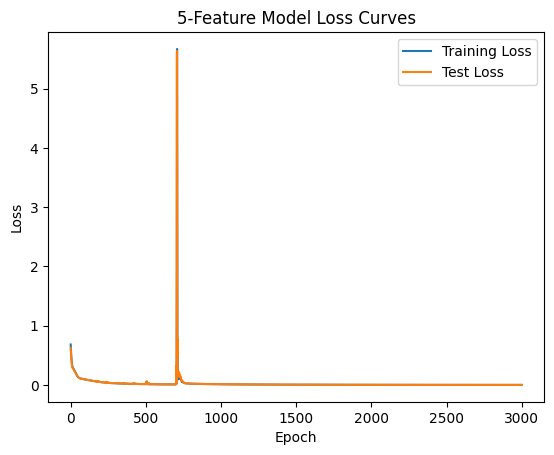

In [7]:

dropped_model_5 = AlarmNet(
    num_features=X_train_5f.shape[1],  # Update to match the new input dimensions
    activation = nn.ReLU,
    hidden_layers=[64, 32]
    
).to(device)
epochs = 3000
alpha = 1e-2

X_train_5f_device = torch.tensor(X_train_5f).float().to(device)
X_test_5f_device = torch.tensor(X_test_5f).float().to(device)
Y_train_5f_device = torch.tensor(Y_train_raw).float().view(-1, 1).to(device)
Y_test_5f_device = torch.tensor(Y_test_raw).float().view(-1, 1).to(device)

dropped_model_5.train(epochs, X_train_5f_device, X_test_5f_device, Y_train_5f_device, Y_test_5f_device, alpha)

dropped_model_5_results = dropped_model_5.get_results()
dropped_model_5.print_results()

AlarmNet.compare_results(dropped_model_5_results, full_model.get_results())

dropped_model_5.plot_training("5-Feature Model Loss Curves")


# Outlier Removal
- The curve above has an odd spike at around 700 epochs. This may be due to the heavily biased distributions of the NC0.5 and TVOC features

array([[<Axes: title={'center': 'Humidity[%]'}>,
        <Axes: title={'center': 'Raw Ethanol'}>],
       [<Axes: title={'center': 'Pressure[hPa]'}>,
        <Axes: title={'center': 'TVOC[ppb]'}>],
       [<Axes: title={'center': 'NC0.5'}>, <Axes: >]], dtype=object)

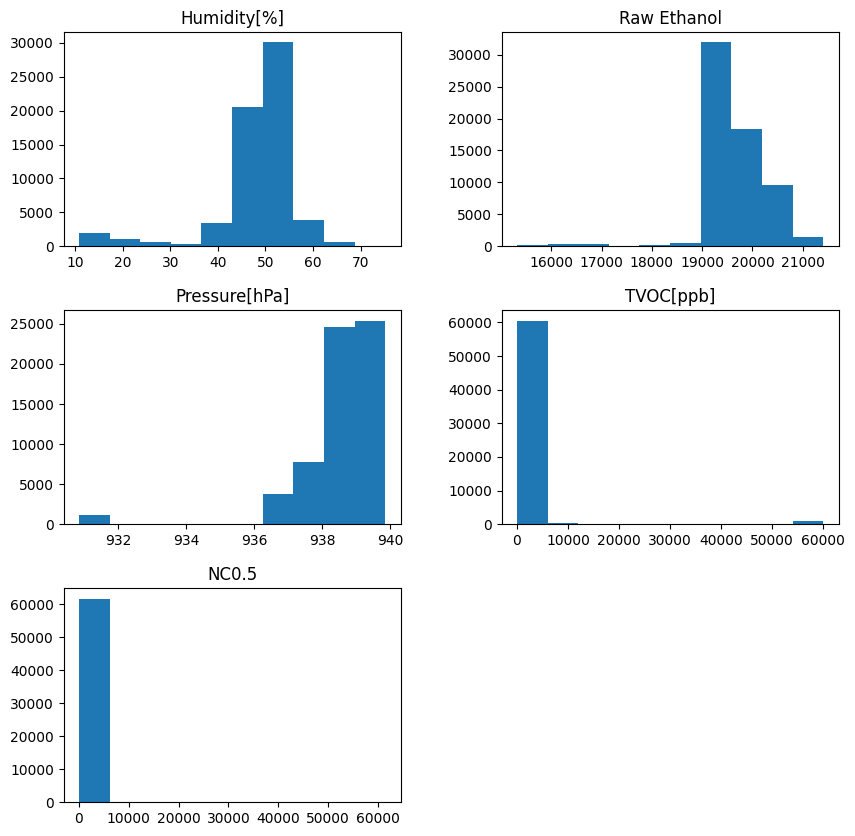

In [12]:
X_5f.hist(figsize=(10, 10), grid=False)

In [13]:
#remove all rows where TVOC>3000 or NC0.5>4000
X_5f_outlier = X_5f[(X_5f['TVOC'] < 3000) & (X_5f['NC0.5'] < 4000)]

X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(X_5f_outlier.values, Y_raw, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_outlier = scaler.fit_transform(X_train_5f)
X_test_outlier = scaler.transform(X_test_5f)

X_train_outlier_device = torch.tensor(X_train_outlier).float().to(device)
X_test_outlier_device = torch.tensor(X_test_outlier).float().to(device)
Y_train_outlier_device = torch.tensor(Y_train_outlier).float().view(-1, 1).to(device)
Y_test_outlier_device = torch.tensor(Y_test_outlier).float().view(-1, 1).to(device)

outlier_model = AlarmNet(
    num_features=X_train_outlier.shape[1],
    activation = nn.ReLU,
    hidden_layers=[64, 64]
).to(device)

outlier_model.train(
    epochs=3000,
    X_train=X_train_outlier_device,
    X_test=X_test_outlier_device,
    Y_train=Y_train_outlier_device,
    Y_test=Y_test_outlier_device,
    alpha=1e-2,
    print_epoch = 500
)
outlier_model.print_results()
AlarmNet.compare_results(outlier_model.get_results(), dropped_model_5_results)
outlier_model.plot_training("Outlier Model Loss Curves")





KeyError: 'TVOC'

In [8]:
import random

# Introduce sensor errors

VOC_features = [
    'TVOC[ppb]',
    'eCO2[ppm]',
    'Raw H2',
    'Raw Ethanol'
]

PM_features = [
    'PM1.0',
    'PM2.5',
    'NC0.5',
    'NC1.0',
    'NC2.5'
]

th_features = [
    'Temperature[C]',
    'Humidity[%]'
]
pressure_features = [
    'Pressure[hPa]'
]

# For each measurement, each sensor has this chance of introducing an error
error_chance = 0.2

# The PM sensor is twice as likely to fail due to lack of redundancy
chances = [error_chance, error_chance*2, error_chance, error_chance]
sensors = [VOC_features, PM_features, th_features, pressure_features]

error_mask = np.ones(X_5f.shape)

# for i, row in error_mask:
#     errored_features = []
#     for j, sensor in enumerate(sensors):
#         sensor_error = random.random() < chances[j]
#         if sensor_error:
#             errored_features.extend(sensor)
#     errored_features = [feature for feature in errored_features if feature in X_error.columns]
#     if errored_features:
#         for feature in errored_features:
#             error_mask[i][X_error.columns.get_loc(feature)] = np.nan
#         print(i, error_mask[i])

X_error_np = X_5f.values.copy()
for i, datapoint in enumerate(X_5f.values):
    errored_features = []
    for j, sensor in enumerate(sensors):
        sensor_error = random.random() < chances[j]
        if sensor_error:
            errored_features.extend(sensor)
    errored_features = [feature for feature in errored_features if feature in X_5f.columns]
    if errored_features:
        for feature in errored_features:
            X_error_np[i][X_5f.columns.get_loc(feature)] = np.nan
        # print(i, X_error_np[i])

X_train_error, X_test_error, Y_train_error, Y_test_error = train_test_split(X_error_np, Y_raw, test_size=0.2, random_state=0)

## Imputation
- Replace each errored value with the mean of that feature from the training data

In [9]:
from sklearn.impute import SimpleImputer


means = X_5f.mean()



imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_5f.values)
imputer.fit(X_train_error)
X_impute_train = imputer.transform(X_train_error)
X_impute_test = imputer.transform(X_test_error)

X_impute_train = scaler.fit_transform(X_impute_train)
X_impute_test = scaler.transform(X_impute_test)

In [10]:
imputed_model = AlarmNet(
    num_features=X_impute_train.shape[1],
    activation = nn.ReLU,
    hidden_layers=[256, 256, 256]
    
).to(device)

X_impute_train_device = torch.tensor(X_impute_train).float().to(device)
X_impute_test_device = torch.tensor(X_impute_test).float().to(device)
Y_train_impute_device = torch.tensor(Y_train_error).float().view(-1, 1).to(device)
Y_test_impute_device = torch.tensor(Y_test_error).float().view(-1, 1).to(device)

imputed_model.train(
    epochs= 10000,
    X_train = X_impute_train_device,
    X_test = X_impute_test_device,
    Y_train = Y_train_impute_device,
    Y_test = Y_test_impute_device,
    alpha= 1e-4,
    loss_fn = nn.BCELoss(),
    optimizer = torch.optim.Adam
)
imputed_model.print_results()
AlarmNet.compare_results(imputed_model.get_results(), dropped_model_5.get_results())
imputed_model.plot_training("Imputed Model Loss Curves")

----------------------------------------
| Epoch | Training Loss |  Test Loss   |
----------------------------------------
|     0 |  0.6820147038 | 0.6785926223 |
----------------------------------------
|   500 |  0.1486586481 | 0.1489401311 |
----------------------------------------
|  1000 |  0.1093622893 | 0.1121867076 |
----------------------------------------
|  1500 |  0.0710166171 | 0.0739967301 |
----------------------------------------
|  2000 |  0.0547742434 | 0.0575675406 |
----------------------------------------
|  2500 |  0.0479005873 | 0.0513693541 |
----------------------------------------
|  3000 |  0.0439794101 | 0.0481321216 |
----------------------------------------
|  3500 |  0.0402701050 | 0.0447094068 |
----------------------------------------
|  4000 |  0.0379090980 | 0.0492288545 |
----------------------------------------
|  4500 |  0.0364982672 | 0.0480179489 |
----------------------------------------
|  5000 |  0.0353378654 | 0.0469659641 |
----------------

KeyboardInterrupt: 

## Error Modes
- Current features:
    - Humidity
    - Raw Ethanol
    - Pressure
    - TVOC
    - NC0.5
- Sensors:
    - Humidity
    - Pressure
    - Raw Ethanol/TVOC
    - NC0.5
- The model should be able to handle missing data in the case where at most 3 sensors have failed, because 4 failed sensors means no data
    - 1 failed sensor = 4c1 = 4
    - 2 failed sensors = 4c2 = 6
    - 3 failed sensors = 4c3 = 4
    - Total = 14
## Ensemble Training
- We can train 14 models that can predict the missing data for each error mode
- In the case of error, we select the model that corresponds to the error mode and use it to predict the missing data
- Then use the main model to predict the target
### Indexing Ensemble
- Columns should be rearranged according to sensors
    - Humidity, Pressure, NC0.5, Ethanol, TVOC, 
- The error mode can be represented as a 4-bit value
    - 0b0000 = No error
    - 0b0001 = Ethanol/TVOC Error
    - 0b0010 = NC0.5 Error
    - 0b0100 = Pressure error
    - 0b1000 = Humidity error
- A 5-bit value can represent which features are missing
    - 0b00000 = No error
    - 0b00011 = Ethanol/TVOC Error
    - 0b00100 = NC0.5 Error
    - 0b01000 = Pressure error
    - 0b10000 = Humidity error
- We can convert from the 5-bit value to the 4-bit value with a simple shift right operation

### Model Table
- Store the models with an array
- The index of the model is the error mode
- Model 15 will always predict 1, because if all sensors have failed the worst should be assumed for safety
- Model 0 will be the standard model trained on a full dataset
- The rest of the arrays will be trained on the data with the corresponding error mode
### New Model Type
- A new model class will be created that will predict the missing values, construct the repaired dataset, call the standard model, and return the result
### Ensemble Class
- This new class will hold the model table and the standard model
- It will be responsible for constructing the model address, calling the correct model, and returning the result



    

